## Comparison of quasi-elastic $(p,n)$ differential cross sections between jitR and CHEX

CHEX uses more rudimentary kinematics, which leads to the slight difference.

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [2]:
import jitr

In [3]:
# initial and final systems
proton = (1, 1)
neutron = (1, 0)

# Core p + Ca48
Ca48 = (48, 20)

# n + IAS
Sc48 = (48, 21)

# lab bombarding energy
E_lab = 35  # MeV

# excitation energy to isobaric analog state
E_IAS = 6.67  # MeV

reaction = jitr.reactions.Reaction(
    target=Ca48, projectile=proton, product=neutron, residual=Sc48
)

In [4]:
kd_default_p = jitr.optical_potentials.kduq.Global(
    proton, jitr.data_dir / Path("KD_default.json")
)
kd_default_n = jitr.optical_potentials.kduq.Global(
    neutron, jitr.data_dir / Path("KD_default.json")
)

In [5]:
kinematics_entrance = reaction.kinematics(E_lab)
kinematics_exit = reaction.kinematics_exit(
    kinematics_entrance, residual_excitation_energy=E_IAS
)

In [6]:
kinematics_entrance

ChannelKinematics(Elab=35, Ecm=34.27976496842483, mu=951.4664814091528, k=1.28287146975579, eta=0.5485537668413036)

In [7]:
kinematics_exit

ChannelKinematics(Elab=27.676442482181717, Ecm=27.106217022054977, mu=945.9138169852782, k=1.13952205754593, eta=0.0)

In [9]:
channel_radius_fm = 16  # fm
lmax = 20
angles = np.linspace(0.01, np.pi, 200)

In [10]:
core_solver = jitr.rmatrix.Solver(nbasis=30)

In [11]:
workspace = jitr.xs.quasielastic_pn.Workspace(
    reaction,
    kinematics_entrance,
    kinematics_exit,
    core_solver,
    angles,
    lmax,
    channel_radius_fm,
    tmatrix_abs_tol=1.0e-16,
)

In [12]:
# get parameters
coul_p, central_params_p, spin_orbit_params_p = kd_default_p.get_params(
    *Ca48, kinematics_entrance.Elab
)

coul_n, central_params_n, spin_orbit_params_n = kd_default_n.get_params(
    *Sc48, kinematics_exit.Elab
)

In [13]:
xs = workspace.xs(
    jitr.optical_potentials.potential_forms.coulomb_charged_sphere,
    jitr.optical_potentials.kduq.central,
    jitr.optical_potentials.kduq.spin_orbit,
    jitr.optical_potentials.kduq.central,
    jitr.optical_potentials.kduq.spin_orbit,
    args_p_coulomb=coul_p,
    args_p_central=central_params_p,
    args_p_spin_orbit=spin_orbit_params_p,
    args_n_central=central_params_n,
    args_n_spin_orbit=spin_orbit_params_n,
)

In [14]:
xspn = pd.read_csv(
    "./chex_qepn_xs.txt",
    names=["theta", "dxs", "err"],
    sep="\s+",
)

In [15]:
ca48_pn_ias = np.array(
    [
        [0.0000, 0.70000, 0.035000],
        [3.0700, 0.61300, 0.047000],
        [10.240, 0.68200, 0.050000],
        [15.360, 1.1800, 0.061000],
        [20.480, 2.5452, 0.073000],
        [25.590, 3.4110, 0.090000],
        [30.700, 2.9580, 0.084000],
        [35.800, 1.7724, 0.063000],
        [40.900, 1.1964, 0.053000],
        [51.070, 1.0356, 0.040000],
        [61.210, 1.0536, 0.035000],
        [81.380, 0.23300, 0.020000],
        [91.400, 0.22600, 0.017000],
        [101.37, 0.15000, 0.016000],
        [111.31, 0.064000, 0.0100000],
        [121.21, 0.094000, 0.012000],
        [131.07, 0.053000, 0.011000],
    ]
)

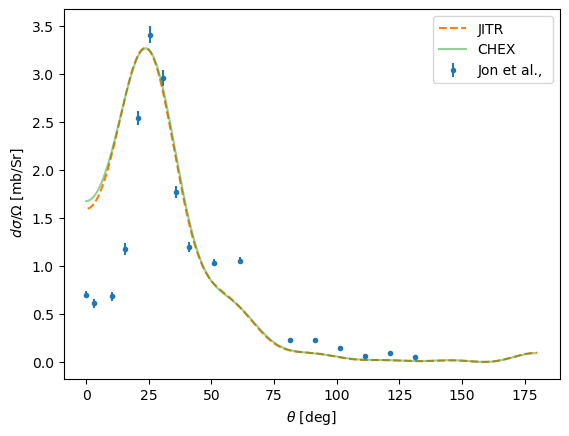

In [22]:
plt.errorbar(
    ca48_pn_ias[:, 0],
    ca48_pn_ias[:, 1],
    yerr=ca48_pn_ias[:, 2],
    label="Jon et al., ",
    linestyle="none",
    marker=".",
)

plt.plot(workspace.angles * 180 / np.pi, xs, "--", label="JITR")
plt.plot(xspn["theta"], xspn["dxs"], label="CHEX", alpha=0.5)
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $d \sigma / \Omega$ [mb/Sr]")
plt.legend()